This is a simulation of the rerouting algorithm. We will be using the PUJ route T307 (Boni - Pinatubo → Stop n' Shop).

In [1]:
!pip3 install -q osmnx contextily overpass overpy osmapi

  You can safely remove it manually.
  You can safely remove it manually.


In [10]:
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import pandas as pd
import osmnx as ox
import random
import json
import geopandas as gpd


import overpass
from shapely.geometry import Polygon, LineString, Point
import overpy
from osmapi import OsmApi

## Prepare Data

### Creating Bounding Box

In [70]:
BOUNDING_BOX = (14.60692, 14.56838, 121.06303, 120.99891) # bounding box as (north, south, east, west)
graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)

/tmp/ipykernel_148/3675650549.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)


### Plot Area

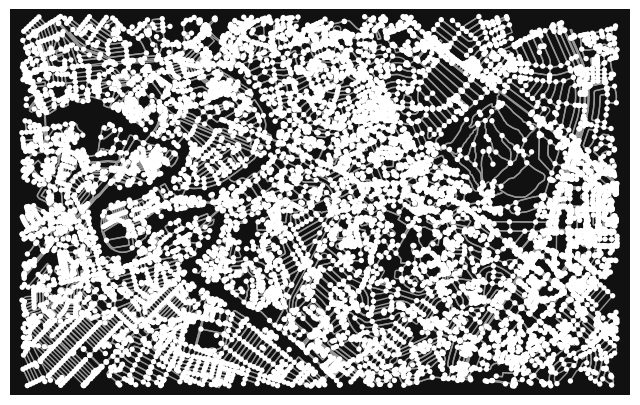

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [71]:
ox.plot_graph(graph_of_area)

In [5]:
gdf_edges = ox.graph_to_gdfs(graph_of_area, nodes=False)

In [6]:
gdf_edges.head()

osmid  oneway lanes  ref  \
u        v          key                                                        
12067613 1981388318 0                           264965502    True     4    1   
         962953430  0    [29256184, 188165094, 188165111]    True     2    1   
12067619 6970838871 0                          1254512972    True   NaN  NaN   
         8459730704 0                           671955931    True     2    1   
12067627 8242414108 0                            22598208   False     2  NaN   

                                          name   highway maxspeed reversed  \
u        v          key                                                      
12067613 1981388318 0                     EDSA     trunk       60    False   
         962953430  0                     EDSA     trunk       60    False   
12067619 6970838871 0    Starmall Service Road   service      NaN    False   
         8459730704 0                     EDSA     trunk       60    False   
12067627 8242414108 0               Apo Street  tertiary      NaN    False   

                          length tunnel  \
u        v          key                   
12067613 1981388318 0     15.937    NaN   
         962953430  0    860.735    yes   
12067619 6970838871 0      5.014    NaN   
         8459730704 0    199.554    NaN   
12067627 8242414108 0      6.785    NaN   

                                                                  geometry  \
u        v          key                                                      
12067613 1981388318 0    LINESTRING (121.05548 14.58452, 121.05537 14.5...   
         962953430  0    LINESTRING (121.05548 14.58452, 121.05543 14.5...   
12067619 6970838871 0    LINESTRING (121.05468 14.58309, 121.05464 14.5...   
         8459730704 0    LINESTRING (121.05468 14.58309, 121.05400 14.5...   
12067627 8242414108 0    LINESTRING (121.04673 14.57158, 121.04667 14.5...   

                             access service width junction bridge  
u        v          key                                            
12067613 1981388318 0           NaN     NaN   NaN      NaN    NaN  
         962953430  0           NaN     NaN   NaN      NaN    NaN  
12067619 6970838871 0    permissive     NaN   NaN      NaN    NaN  
         8459730704 0           NaN     NaN   NaN      NaN    NaN  
12067627 8242414108 0           NaN     NaN   NaN      NaN    NaN

In [7]:
gdf_edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
gdf_edges_web_mercator = gdf_edges.to_crs(epsg=3857)

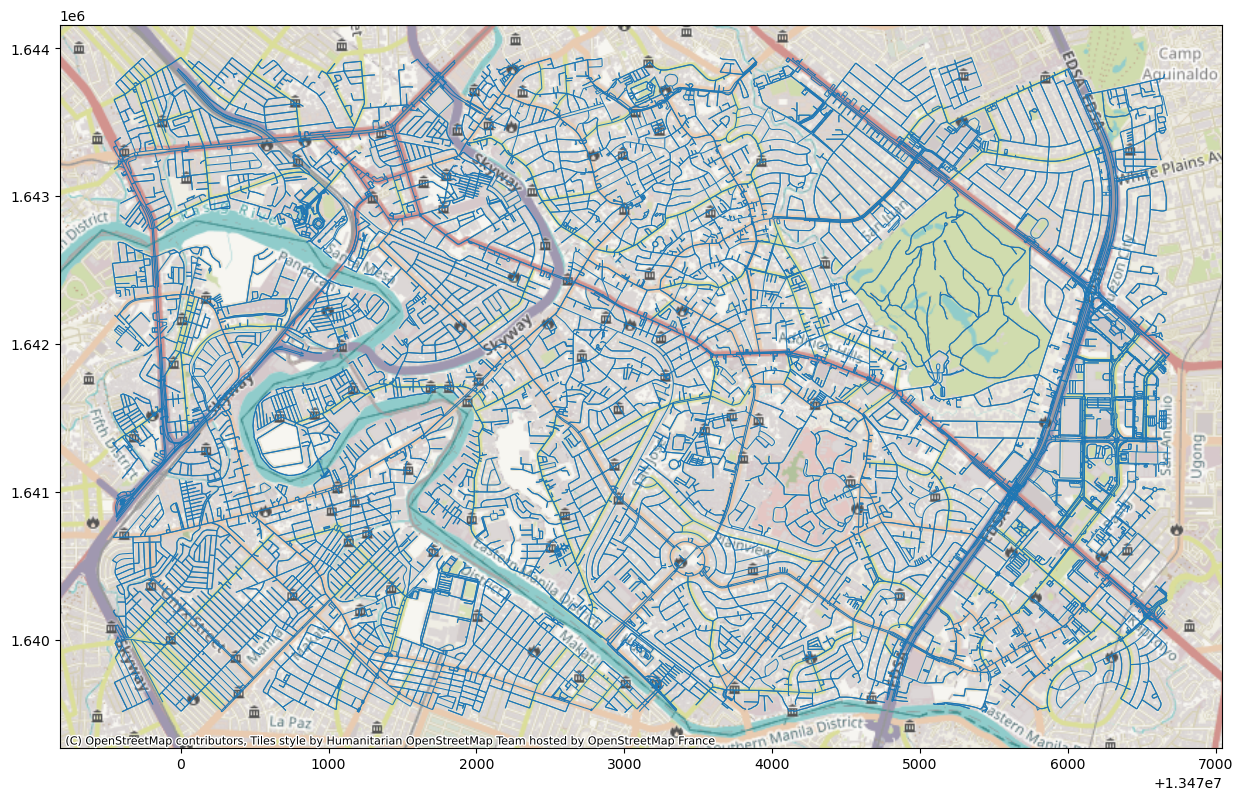

In [9]:
_, ax = plt.subplots(1,1, figsize=(15,15))
gdf_edges_web_mercator.plot(linewidth=.75, ax=ax)
cx.add_basemap(ax=ax, url=cx.providers.CartoDB.Positron)

### Using overpy

In [11]:
# Initialize Overpass API
api = overpy.Overpass()

# Specify the relation ID you want to query
relation_id = 11246072  # Replace with the actual relation ID

In [12]:
# Query to fetch the relation by ID
query = f"""
relation({relation_id});
out body;
"""

# Fetch the relation data
result = api.query(query)

# Check if we got the relation
if len(result.relations) > 0:
    relation = result.relations[0]  # Access the first relation
else:
    print("No relation found.")

In [13]:
node_ids = []
way_ids = []
for member in relation.members:
    if type(member) == overpy.RelationNode:
        node_ids.append(member.ref)
    elif type(member) == overpy.RelationWay:
        way_ids.append(member.ref)

In [14]:
query = f"""
node(id:{','.join(map(str, node_ids))});
out body;
"""
result = api.query(query)
    
def get_nodes():
    for node in result.get_nodes():
        yield Point(node.lon, node.lat)

In [15]:
query = f"""
way(id:{','.join(map(str, way_ids))});
out body;
"""
result = api.query(query)

def get_ways():
    for way in result.get_ways():
        yield LineString(Point(node.lon, node.lat) for node in way.get_nodes(resolve_missing=True)) 

In [ ]:
# initialize node%alias_magic ids
for way in result.get_ways():
    way.get_nodes(resolve_missing=True)

In [99]:
# initialize node%alias_magic ids
paths = []
for way in result.get_ways():
    paths.append(node.id for node in way.get_nodes(resolve_missing=True))

### Create Subgraph

In [93]:
subgraph = graph_of_area.subgraph(result.get_node_ids())

In [100]:
G = graph_of_area.copy()
all_edges = set()
for path in paths:
    path = list(path)
    for u, v in zip(path[:-1], path[1:]):  # Pair consecutive nodes in each path
        if G.has_edge(u, v):
            # Add the edge including its key if it's a MultiDiGraph
            for key in G[u][v]:
                all_edges.add((u, v, key))

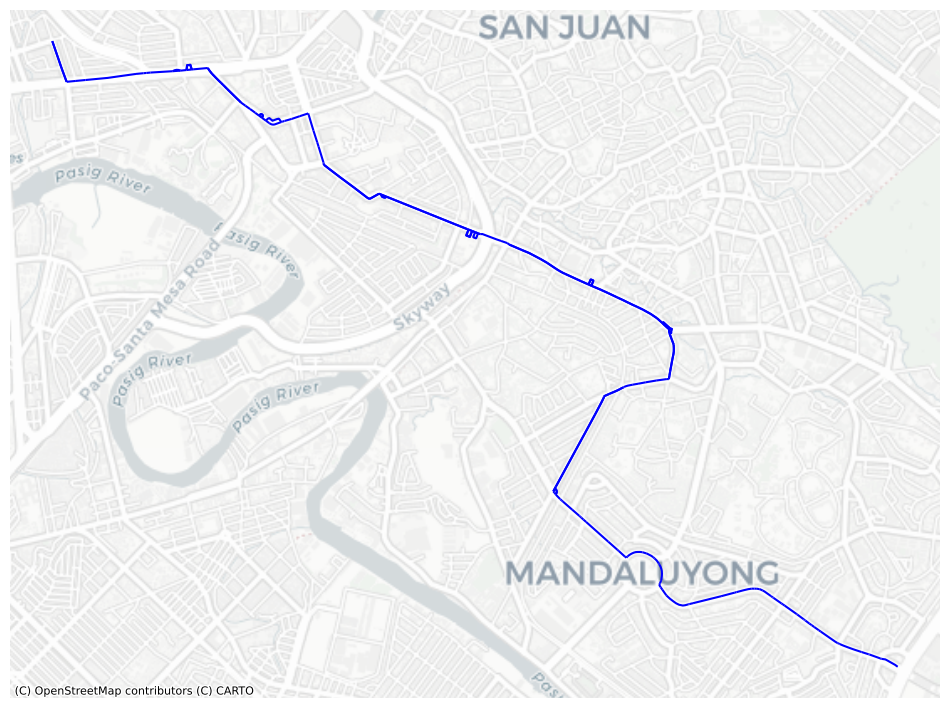

In [94]:
subgraph_edges = ox.graph_to_gdfs(subgraph, nodes=False)
_, ax = plt.subplots(figsize=(12, 12))
subgraph_edges = subgraph_edges.to_crs(epsg=3857)
subgraph_edges.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

### Simulate sample flooding and rerouting

In [78]:
G = graph_of_area.copy()
G_sub = subgraph.copy()

source = result.get_node_ids()[0]
target = result.get_node_ids()[-1]

In [79]:
# Randomly delete nodes in the subgraph
num_nodes_to_delete = 5  # Adjust based on your requirements
deleted_nodes = random.sample(list(G_sub.nodes), num_nodes_to_delete)

# List of randomly deleted nodes
print("Deleted nodes:", deleted_nodes)

Deleted nodes: [237019173, 1190345334, 11613447650, 6141858082, 2616905588]


In [ ]:
# Find two closest nodes in the main graph for each deleted node using osmnx.distance.nearest_nodes
closest_nodes = {}
for node in deleted_nodes:
    # Use osmnx.nearest_nodes to find closest nodes in the main graph
    x, y = G.nodes[node]['x'], G.nodes[node]['y']  # Assuming nodes have x and y coordinates
    closest_node_main_graph = ox.distance.nearest_nodes(G, x, y)

    # Get neighbors of deleted node in the subgraph (only remaining nodes)
    remaining_nodes = list(G_sub.nodes)
    distances = [(n, nx.shortest_path_length(G, source=node, target=n)) for n in remaining_nodes if n != node]
    sorted_distances = sorted(distances, key=lambda d: d[1])[:2]  # Get two closest nodes
    closest_nodes[node] = sorted_distances
    G.remove_node(node)

print("Closest nodes to each deleted node:", closest_nodes)

In [76]:
for node_id in deleted_nodes:
    G.remove_node(node_id)

In [80]:
shortest_path = nx.shortest_path(G, source=source, target=target, weight="length")  # Adjust weight as needed
print("Shortest path from source to target:", shortest_path)

NodeNotFound: Either source 26365570 or target 6698508125 is not in G

### Visualize the result

In [49]:
new_route = G.subgraph(shortest_path)

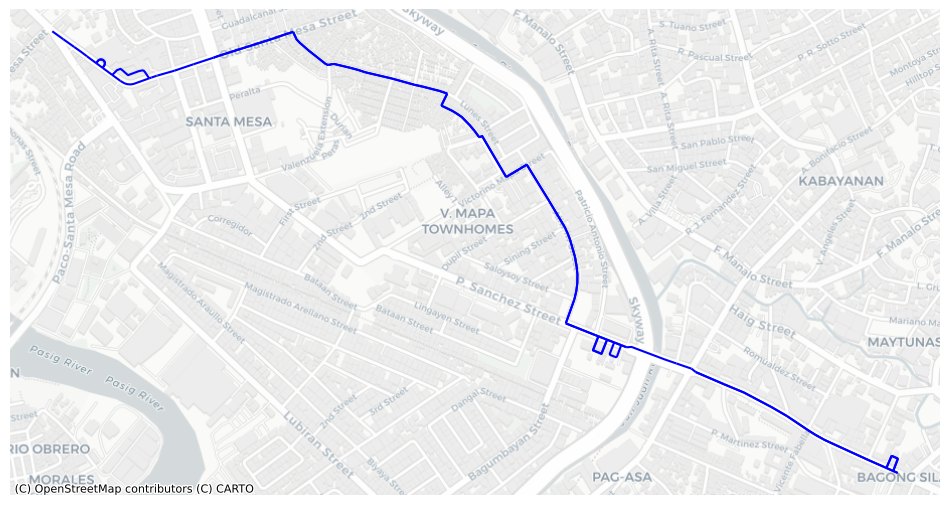

In [50]:
new_route_edges = ox.graph_to_gdfs(new_route, nodes=False)
_, ax = plt.subplots(figsize=(12, 12))
new_route_edges = new_route_edges.to_crs(epsg=3857)
new_route_edges.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

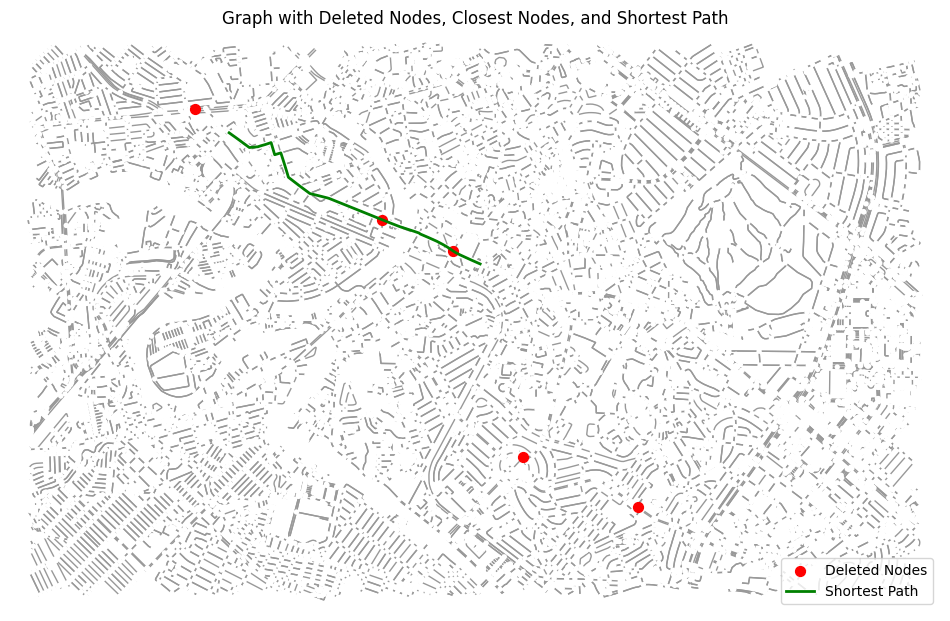

In [174]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, show=False, close=False)

# Plot deleted nodes
deleted_node_x = [G.nodes[node]['x'] for node in deleted_nodes]
deleted_node_y = [G.nodes[node]['y'] for node in deleted_nodes]
ax.scatter(deleted_node_x, deleted_node_y, c='red', s=50, label='Deleted Nodes')

# Plot shortest path
path_x = [G.nodes[n]['x'] for n in shortest_path]
path_y = [G.nodes[n]['y'] for n in shortest_path]
ax.plot(path_x, path_y, c='green', linewidth=2, label='Shortest Path')

# Customize plot
plt.title("Graph with Deleted Nodes, Closest Nodes, and Shortest Path")
plt.legend()
plt.show()

### Plotting Route

In [65]:
# Create a GeoDataFrame for ways
gdf_way_points = gpd.GeoSeries(pd.Series(get_ways()), crs="EPSG:4326") # WGS84

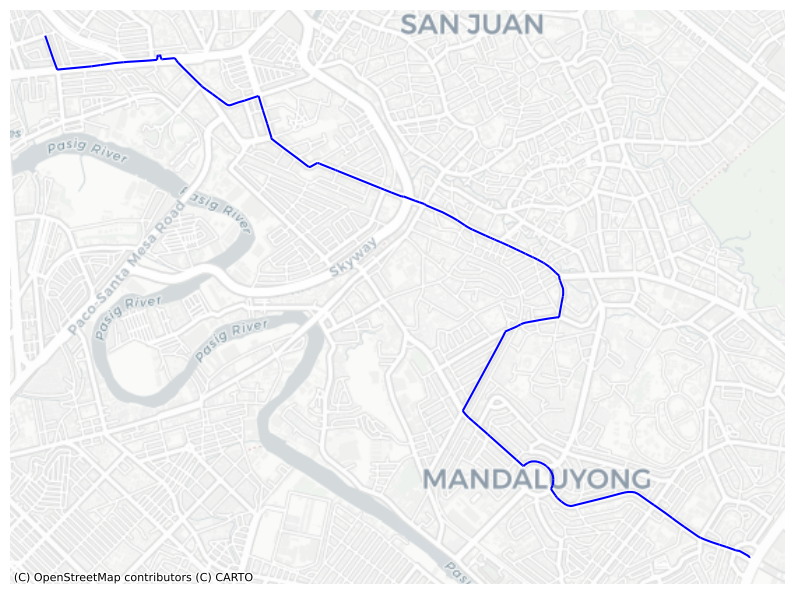

In [66]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_ways_wm = gdf_way_points.to_crs(epsg=3857)
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Plotting nodes.

In [67]:
# Create a GeoDataFrame for ways
gdf_node_points = gpd.GeoSeries(pd.Series(get_nodes()), crs="EPSG:4326")  # WGS84

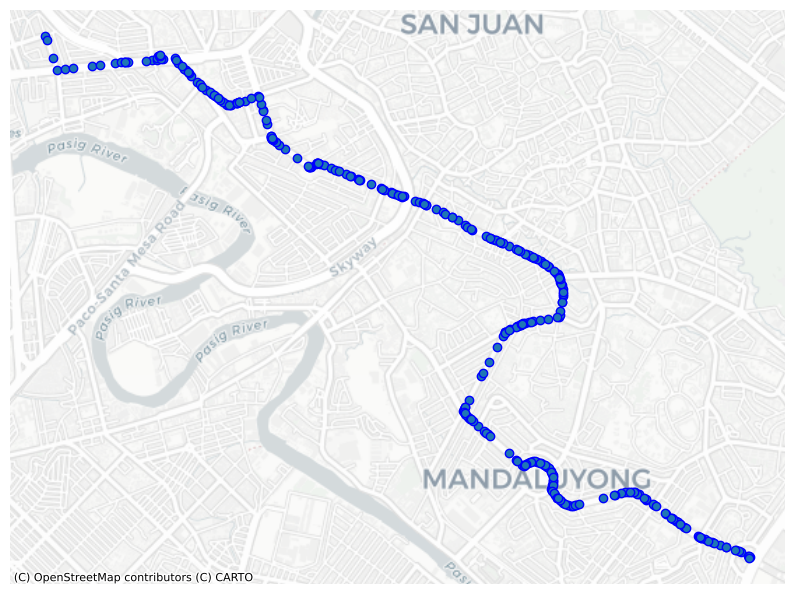

In [68]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm = gdf_node_points.to_crs(epsg=3857)
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Now, let's overlay the nodes and the ways together.

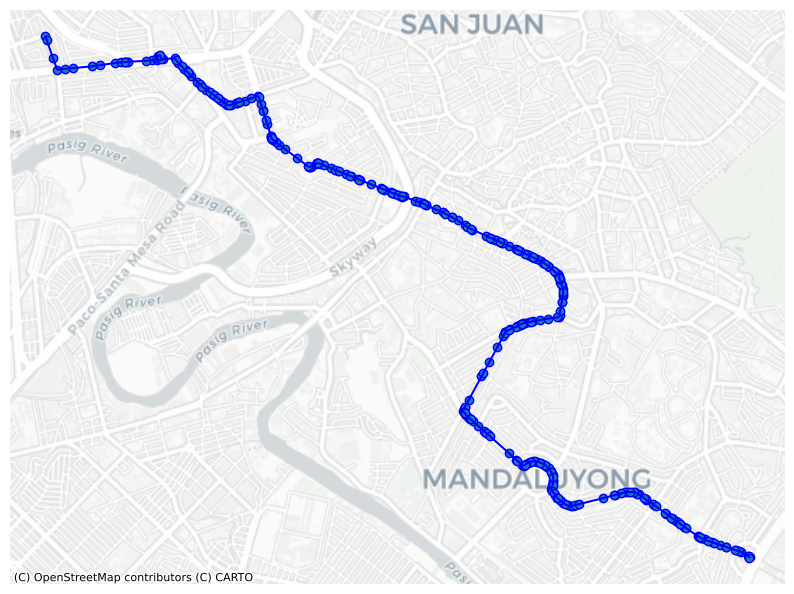

In [69]:
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

# Conclusion